<a href="https://colab.research.google.com/github/AvishekRoy16/DeepLearning/blob/master/1_LargeCNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Outline

1. Loading datasets - Transforming images
2. VGG-16 with modification to network head
3. Using pre-trained models
4. Storing intermediate models
5. Resnet
6. Inception v3
7. Exercises

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
print(device)

cuda:0


## Dataset, transforms, and visualisation

In [ ]:
# We can load the training the test and train differently as we might want to do some tranformations or augmentations to the data, but in this example we are not doing that particularly.
# So basically here we have created two different objects for train and test.
transforms_train = transforms.Compose([
    # We are resizing the image as the vgg template that we are using call for it.
    # We have cropped the image from different locations so as to preserve the aspect ratio.
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    # Here we are normalising the RGB channels by giving them a mean and standard deviation of 0.5. We do this because the different color can have very different variation in a histogram
    # and the neural network will have to store it, but here we have preprocessed it so that the network does not have to compansate.
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize((mean for 3 channels), (std. for 3 channels))
    ])

transforms_test = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5) )
    ])

In [ ]:
# Downloading the dataset and storing it locally, and then transforming the images using the transformers that we made earlier.
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True,
                                        transform=transforms_train)                                         

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True,
                                        transform=transforms_test)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Number of classes
num_classes = 10

In [ ]:
batch_size = 4

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [ ]:
# Instanciating a iterator for this train loader
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels[1].item())
# The output has 4 images in a batch, contains 3 channels in a batch & it contains x and y dimentions of the images.

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
2


In [ ]:
# To plot the image we have to do one modification  - we will have to convert the image into numpy and then un-normalise it.

def imshow(img, title):
  npimg = img.numpy() / 2 + 0.5    # De-normalization is performed (/2 is to remove standard deviation - as it is equvalent to dividing by .5) (+0.5 is adding the mean)
  # the width of the image is batch size - 4 for out case
  plt.figure(figsize=(batch_size, 1))
  plt.axis('off')
  # This is to transpose the image so that the image axis comes first then the channels come - at the very end
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.title(title)
  plt.show()

In [ ]:
def show_batch_images(dataloader):
  images, labels = next(iter(dataloader))
  # puts together the images to show together
  img = torchvision.utils.make_grid(images)
  # Here we are usiing the titles as the lables of all the images
  imshow(img, title=[str(x.item()) for x in labels])

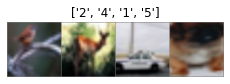

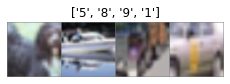

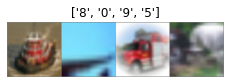

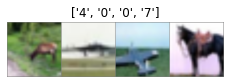

In [ ]:
for i in range(4):
  show_batch_images(trainloader)

## Creating VGG-16

[VGGNet Model](https://pytorch.org/docs/master/_modules/torchvision/models/vgg.html)

In [ ]:
# For the very popular network the torchvision officially supports the definations of the model architectures.
from torchvision import models

In [ ]:
# Here bn stands for batch normalisation
vgg = models.vgg16_bn()

In [ ]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
print(vgg.features[0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [ ]:
print(vgg.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


In [ ]:
# In CIFAR 10 there are only 10 classes but as we can see that the last layer of vgg classifier has 1000 we have to change that
final_in_features = vgg.classifier[6].in_features
# We are makeing a modified classifier by dropping the last one which has the wrong weights. Then adding it seperately
mod_classifier = list(vgg.classifier.children())[:-1]
mod_classifier.extend([nn.Linear(final_in_features, num_classes)])
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [ ]:
# Then finally we will change the modified classifier to the vgg network -> with 10 out features
vgg.classifier = nn.Sequential(*mod_classifier)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

## Train CIFAR10

In [ ]:
# We are taking 16 as batch size as it allows us to have a good amount of images to make small steps in gradients so that a single photo cannot persuade the whole operation.
# We are not taking it bigger than that as we have to store all the weights and biases on the gpu, and vgg in itself is a big netowrk so we might get "out of memory on gpu"
batch_size = 16

# Modifying the train and testloaders with the new batch size.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
def evaluation(dataloader, model):
  total, correct = 0, 0
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()
  return 100 * correct / total

In [ ]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

In [ ]:
# Usual Learning Loop
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):
  
  # We will iterate over each batch
  for i, data in enumerate(trainloader, 0):
    
    # Get the inputs and the lables and move them to the GPU
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Reset our gradients
    opt.zero_grad()
    
    # The forward pass
    outputs = vgg(inputs)
    # The backward pass
    loss = loss_fn(outputs, labels)
    loss.backward()
    # Optimisers where we do the weight updates
    opt.step()
    
    # Attemps at ensuring that the memory usage is in the gpu is small
    del inputs, labels, outputs
    torch.cuda.empty_cache()
    
    # IN every 100 iterations we are printing out the loss that we have
    if i % 100 == 0:
      print(f"Iteration: {i}/{n_iters}, Loss:{loss.item():0.2f}")
      print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
      
  # After each batch appending the loss to an array
  loss_epoch_arr.append(loss.item())
  
  print(f"----------------------------------\nEpoch: {epoch}/{max_epochs}\nTest acc: {evaluation(testloader, vgg):0.2f}\nTrain acc: {evaluation(trainloader, vgg):0.2f}\n----------------------------------")
  

plt.plot(loss_epoch_arr)
plt.show()
# We have 10 classes - if we take a ln(10) then we get 2.3 which means that, a loss of 2.3 is what a random classifier would have
# Also this is taking very long to train so this is definately not the best way to do it. Especially when it take this much time for only one eopoch

Iteration: 0/3125.0, Loss:2.27
Iteration: 0/3125, Loss: 2.27
Iteration: 100/3125.0, Loss:3.12
Iteration: 100/3125, Loss: 3.12
Iteration: 200/3125.0, Loss:2.61
Iteration: 200/3125, Loss: 2.61
Iteration: 300/3125.0, Loss:2.41
Iteration: 300/3125, Loss: 2.41
Iteration: 400/3125.0, Loss:2.28
Iteration: 400/3125, Loss: 2.28
Iteration: 500/3125.0, Loss:2.29
Iteration: 500/3125, Loss: 2.29
Iteration: 600/3125.0, Loss:2.29
Iteration: 600/3125, Loss: 2.29
Iteration: 700/3125.0, Loss:2.31
Iteration: 700/3125, Loss: 2.31


KeyboardInterrupt: ignored

Now as we can se we have got a huge optimisation problem at hand, if we calculate the number of parameters it comes close to 138M params. Being able to train this effeciently and within the given amount of training data becomes a challenge. So instead of training things from scratch, we use **pretrained models** - the idea being that the we are going to use models that have been pre trained on some networks, the weights have been saved and then we can reuse those weights and only train parts of our network

<br>

## Benifits of Transfer Learning

Using pre-trainied models is trained on very large volumes of data, which might be difficult to replicate during manual training with our own dataset.

The number of prarameters to be trained is drasticaly reduced, as we only train a very few layers to fintune the output of the model.

### Freeze layers of Convolutional Operations

In [ ]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testlaoder = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
# Models not only contains pretrained architectures, but also optimised weights and biases - we are not only instanciating the number of layes but also downloading the 138M params
vgg = models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
# Here we are saying that if we are doing a backpropagation don't go update a certain weight or a bias
for param in vgg.parameters():
  param.requires_grad = False  # This ensures that the pretrained weights do not get updated during backpropagation

In [ ]:
# So we are deleting the last layer and adding our own layer - as the model as 1000 ouput features so we would like to make those 10 features. Also as we are training a pretrainied models and
# not doing backpropagation so those parameter are frozen parameters, so by adding last layer of our own we are unfreezing certain parameters
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, num_classes)  # Here, we add our own final classification layer with trainable weights.

In [ ]:
# Only these tensors require an update
for param in vgg.parameters():
    if param.requires_grad:
        print(param.shape) # Here we see two tensors corresponding to the weights (4096x10) and bias (10) terms

torch.Size([10, 4096])
torch.Size([10])


In [ ]:
# Moving to the GPU
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

In [ ]:
# The learning loop
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):
  
  for i, data in enumerate(trainloader, 0):
    
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    
    opt.zero_grad()
    
    outputs = vgg(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()
    
    if i % 100 == 0:
      print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
      
    del inputs, labels, outputs
    torch.cuda.empty_cache()
    
  loss_epoch_arr.append(loss.item())
  
  print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, evaluation(testloader, vgg), evaluation(trainloader, vgg)))
  
plt.plot(loss_epoch_arr)
plt.show()
# As we can see that the loss falls significantly but over time it increases

Iteration: 0/3125, Loss: 2.35
Iteration: 100/3125, Loss: 2.14
Iteration: 200/3125, Loss: 1.41
Iteration: 300/3125, Loss: 2.66
Iteration: 400/3125, Loss: 1.73
Iteration: 500/3125, Loss: 1.18
Iteration: 600/3125, Loss: 2.08
Iteration: 700/3125, Loss: 1.97
Iteration: 800/3125, Loss: 1.34
Iteration: 900/3125, Loss: 2.16
Iteration: 1000/3125, Loss: 1.31
Iteration: 1100/3125, Loss: 1.83
Iteration: 1200/3125, Loss: 2.97
Iteration: 1300/3125, Loss: 1.67
Iteration: 1400/3125, Loss: 2.32


KeyboardInterrupt: ignored

### With model copies

We are able to see that the loss values values flutuates, hence we would like to  store copies of the entire model 

In [ ]:
# Allows us to make deep copies of our network
import copy

In [ ]:
# modified learning loop
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):
  
  for i, data in enumerate(trainloader, 0):
    
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    
    opt.zero_grad()
    
    outputs = vgg(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()
    
    # New part
    if min_loss > loss.item():
      min_loss = loss.item()
      # saving the copy of the best loss
      best_model = copy.deepcopy(vgg.state_dict())
      print('Min loss %0.2f' % min_loss)
      
    if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
    del inputs, labels, outputs
    torch.cuda.empty_cache()
    
  loss_epoch_arr.append(loss.item())

Min loss 1.82
Iteration: 0/3125, Loss: 1.82
Min loss 1.49
Min loss 1.25
Min loss 1.24
Min loss 1.09
Min loss 1.05
Min loss 1.04
Min loss 1.04
Min loss 0.95
Iteration: 100/3125, Loss: 2.29
Min loss 0.87
Iteration: 200/3125, Loss: 1.59
Min loss 0.63
Iteration: 300/3125, Loss: 2.53
Iteration: 400/3125, Loss: 1.75
Min loss 0.47
Iteration: 500/3125, Loss: 2.13
Iteration: 600/3125, Loss: 3.19
Iteration: 700/3125, Loss: 2.65
Iteration: 800/3125, Loss: 1.80
Iteration: 900/3125, Loss: 2.51
Iteration: 1000/3125, Loss: 2.20
Iteration: 1100/3125, Loss: 2.33
Iteration: 1200/3125, Loss: 2.72
Iteration: 1300/3125, Loss: 2.19
Iteration: 1400/3125, Loss: 2.72
Iteration: 1500/3125, Loss: 2.19
Iteration: 1600/3125, Loss: 2.00
Iteration: 1700/3125, Loss: 1.61
Iteration: 1800/3125, Loss: 2.30
Iteration: 1900/3125, Loss: 2.08
Iteration: 2000/3125, Loss: 2.09
Iteration: 2100/3125, Loss: 2.55
Iteration: 2200/3125, Loss: 2.26
Iteration: 2300/3125, Loss: 1.82
Iteration: 2400/3125, Loss: 1.97
Iteration: 2500/312

In [ ]:
# The newtowrk will load all the variables as per the best model.
vgg.load_state_dict(best_model)
print(evaluation(trainloader, vgg), evaluation(testloader, vgg))

45.372 45.18


## ResNet Model

[ResNet Model](https://pytorch.org/docs/master/_modules/torchvision/models/resnet.html)

In [ ]:
resnet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Resnet is also a very large params, hence we will freeze these parameters
for param in resnet.parameters():
    param.requires_grad = False

In [ ]:
# Removing the last linear layer and adding a layer of our own - explanation on the vgg newtwork
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

In [ ]:
for param in resnet.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 512])
torch.Size([10])


In [ ]:
# Move to the device 
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(resnet.parameters(), lr=0.01)

Min loss 2.42
Iteration: 0/3125, Loss: 2.42
Min loss 2.33
Min loss 2.25
Min loss 2.22
Min loss 2.17
Min loss 1.86
Min loss 1.67
Min loss 1.62
Iteration: 100/3125, Loss: 2.00
Min loss 1.62
Min loss 1.60
Min loss 1.58
Min loss 1.46
Min loss 1.46
Min loss 1.35
Iteration: 200/3125, Loss: 1.67
Min loss 1.29
Min loss 1.27
Min loss 1.07
Min loss 1.06
Iteration: 300/3125, Loss: 1.42
Min loss 0.86
Iteration: 400/3125, Loss: 1.53
Iteration: 500/3125, Loss: 1.42
Iteration: 600/3125, Loss: 1.49
Min loss 0.69
Iteration: 700/3125, Loss: 1.11
Iteration: 800/3125, Loss: 1.68
Iteration: 900/3125, Loss: 1.36
Iteration: 1000/3125, Loss: 1.51
Iteration: 1100/3125, Loss: 1.29
Iteration: 1200/3125, Loss: 1.30
Min loss 0.67
Iteration: 1300/3125, Loss: 1.20
Min loss 0.58
Iteration: 1400/3125, Loss: 1.64
Iteration: 1500/3125, Loss: 1.57
Iteration: 1600/3125, Loss: 1.94
Iteration: 1700/3125, Loss: 1.11
Iteration: 1800/3125, Loss: 0.61
Min loss 0.56
Iteration: 1900/3125, Loss: 1.70
Iteration: 2000/3125, Loss: 1.

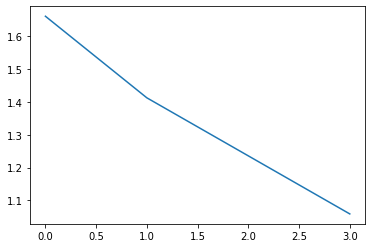

In [ ]:
# Learning Loop
loss_epoch_arr = []
max_epochs = 4

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = resnet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(resnet.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, resnet), evaluation(trainloader, resnet)))
    
    
plt.plot(loss_epoch_arr)
plt.show()
# We can see that the loss is on the lower side as compared to vgg and every epoch we are also computing test and train accuracy
# The accuracy is nowhere close to the best results we can get, by tweeking the hyperparameters and training them much longer we can get much improved accuracy

In [ ]:
# Picking the best model - but sometimes the best loss model is not the one with the best accuracy
# So it is a good idea to start the model out from the best model we got and retrain.
resnet.load_state_dict(best_model)
print(evaluation(trainloader, resnet), evaluation(testloader, resnet))

57.834 57.56


## Inception Model

[Inception Model](https://pytorch.org/docs/master/_modules/torchvision/models/inception.html)



![alt text](https://cloud.google.com/tpu/docs/images/inceptionv3onc--oview.png)

In [ ]:
inception = models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [ ]:
print(inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
# Freezing the params
for param in inception.parameters():
    param.requires_grad = False

In [ ]:
# Change the number of classes in the auxilary output to be 10, as auxilary will be flattened for better gradient flow
aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

In [ ]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])


In [ ]:
# We have to also change the number of classes in the output.
in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, num_classes)

In [ ]:
# As we can see 4 params to be changed - first 2 corresponding to the aux output and the last two to the final layer outpyt
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])
torch.Size([10, 2048])
torch.Size([10])


In [ ]:
# Changing the input size to 299x299x3
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [ ]:
# Here the good part is that the datasets are not being downloaded again, as they aleady were when we did it for vgg, only transforms are being applied to them
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
batch_size=16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
inception = inception.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(inception.parameters(), lr=0.01)

In [ ]:
# Modified funciion as we have auxilary inputs
def evaluation_inception(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # Here outputs get only x and aux get the aux as returned by the function internally
        outputs, aux_outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

Min loss 3.04
Iteration: 0/3125, Loss: 3.04
Min loss 2.98
Min loss 2.93
Min loss 2.86
Min loss 2.81
Min loss 2.72
Min loss 2.69
Min loss 2.67
Min loss 2.54
Iteration: 100/3125, Loss: 2.63
Min loss 2.53
Min loss 2.51
Min loss 2.50
Min loss 2.46
Min loss 2.38
Min loss 2.35
Min loss 2.34
Min loss 2.21
Iteration: 200/3125, Loss: 2.56
Min loss 2.20
Min loss 2.15
Min loss 2.08
Iteration: 300/3125, Loss: 2.69
Min loss 2.07
Min loss 2.04
Min loss 2.01
Min loss 1.92
Min loss 1.85
Min loss 1.81
Iteration: 400/3125, Loss: 2.42
Min loss 1.79
Min loss 1.77
Iteration: 500/3125, Loss: 2.19
Min loss 1.69
Iteration: 600/3125, Loss: 2.27
Min loss 1.65
Min loss 1.47
Iteration: 700/3125, Loss: 2.08
Iteration: 800/3125, Loss: 2.08
Min loss 1.36
Iteration: 900/3125, Loss: 2.08
Iteration: 1000/3125, Loss: 2.14
Iteration: 1100/3125, Loss: 1.95
Iteration: 1200/3125, Loss: 2.32
Iteration: 1300/3125, Loss: 2.45
Min loss 1.34
Iteration: 1400/3125, Loss: 2.26
Min loss 1.10
Iteration: 1500/3125, Loss: 2.63
Iteratio

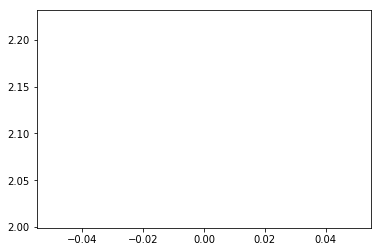

In [ ]:
# Learning Loop - first time we are seeing that loss is computed in two parts
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs, aux_outputs = inception(inputs)
        loss = loss_fn(outputs, labels) + 0.3 * loss_fn(aux_outputs, labels)  # Auxiliary loss function is given a weight of 0.3, as it is less crucial than the main loss

        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(inception.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation_inception(testloader, inception), 
        evaluation_inception(trainloader, inception)))
    
        """
        Loss of a completely random classifier would be calculated as ln(output_classes)
        In this case, since we have two loss functions weighted 1 and 0.3 with 10 output classes, random classifier loss would be around 1.3ln(10)
        """
    
    
plt.plot(loss_epoch_arr)
plt.show()
# So here we can say that 1.3*ln(10) is a good base line for a random classifier - so somewhere around 3

In [ ]:
inception.load_state_dict(best_model)
print(evaluation_inception(trainloader, inception), evaluation_inception(testloader, inception))

47.142 47.39


## Exercises

1. Structure the above code into a series of functions and then call each model

2. Try out different hyperparameter combinations and try to achieve published results on different networks

3. Try out the CIFAR100 and STL10 datasets

4. Try out another model - SqueezeNet

5. Try training multiple layers and not just the last one